# Practical Data Science - Assignment 2

The objective of this assignement was to investigate the value of personal connections in times of finanancial crisis, similar to the procedure taht Acemoglu et. al (2016) followed.


Firstly, we import the required libraries and create the dictionary of the companies to be monitored and the S&P500 index. As it has been found out, there is a package through the Google Finance API that would make the downloading of the data less complicated and probably faster. However, as a more general approach, web scrapping was used to acquire the data in this case.

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


stock_dict={'NYSE%3ABK':'BANK_OF_NY_MELLON_CORP',
             'NASDAQ%3ABFED':'BEACON_FED_BANC_INCORP',
             'NYSE%3ABLK':'BLACKROCK_INCO',
             'NASDAQ%3ACARV':'CARVER_BANCORP_INCO',
             'NYSE%3AC':'CITI_GROUP_INCO',
             'NASDAQ%3ACME':'CME_GROUP_INCO',
             'NYSE%3AEVR':'EVERCORE_PARTNERS_INCO',
             'NYSE%3AFII':'FEDERATED_INVRS_INCO',
             'NYSE%3AFIG':'FORTRESS_INV_GP_LLC',
             'NYSE%3AGBL':'GAMCO_INVESTORS_INCO',
             'NYSE%3ALAZ':'LAZARD_LTD',
             'NASDAQ%3ANTRS':'NORTHERN_TRUST_CORP',
             'NASDAQ%3ABPOP':'POPULAR_INCO',
             'NYSE%3APFS':'PROVIDENT_FINL_SVS_INCO',
             'NYSE%3ASTT':'STATE_STREET_CORP',
             'NYSE%3ABX':'THE_BLACKSTONE_GROUP_LP',
             'NASDAQ%3ANDAQ':'THE_NASDAQ_OMX_GP_INCO',
             'INDEXSP%3A.INX':'SP_500_Index'}

For question 1 we are looking to scrape data for 10 business days after the event day, where the event day is when Geithner's appointment was made.

The data was found online on Google finance and was downloaded using  requests and Beautifulsoup libraries.

It should be noted that Beacon Fed Bank did not have any available data, as it has merged with another company. For this reason the scrapping procedure was set inside a try-catch, and an exception would be raised of type "AttributeError" would print a message that 

_"Data could not be retrieved from XX company"_

This specific company could have been removed from the dictionary above, but it was left there on purpose, so as to gain familirity with exceptions in Python.

Also, the daily return of a company was computed as:

_(Closing Price - Opening Price)/Opening price_

with Opening and Closing prices being from the same day.

As the search on Google finance regarding historical prices is made through the GET method in HTML, building a URL and directly scrapping data from that URL would be more efficient, especially as the monitored companies are less than 20. 

In [2]:
# Set the dates that the scrapping will happen in between
start_date="Nov+21%2C+2008"
end_date="Dec+8%2C+2008"


Grouped=pd.DataFrame()

for stock_code in stock_dict:
    url="https://www.google.com/finance/historical?q="+stock_code+"&startdate="+start_date+"&enddate="+end_date 
    html=requests.get(url).content
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find("table", {"class":"gf-table historical_price"}) # after inspection of the html code, this the class of the table with the data
    stock_data=[] # empty the list

    try:
        for row in table.find_all("tr"):
            cols=row.find_all("td")         
            cols =cols[0].get_text().split("\n") #data acquired per day with line spaces, split it used for easier handling of the data             
            stock_data.append(cols) # append all the per day data to a single list
            # select the appropriate values, removing the comma notation for values above one thousand
            Open=pd.to_numeric((pd.Series((x.replace(',','') for x in (stock_data[0][1::7])))),errors='coerce') 
            Close=pd.to_numeric((pd.Series((x.replace(',','') for x in (stock_data[0][4::7])))),errors='coerce')
            Date=pd.Series((x for x in (stock_data[0][0::7])))
            Ret=(100*np.divide(np.subtract(Close,Open),Open)) # compute the return in %
            Company=Ret.to_frame(name=stock_dict[stock_code]) # add the company name to discretise the data
        Grouped[stock_dict[stock_code]]=Company         
    except AttributeError:  # raise exception when data is missing
        print("Could not retrieve data for " +stock_dict[stock_code]+".")

sp_event_days=pd.DataFrame()
Grouped.loc['Cummulative']=(np.prod(((Grouped+100)/100),0)-1).transpose() # add cummulative row
sp_dropped=Grouped.drop('SP_500_Index',1) # create df without the SP index for later use
sp_event_days['SP_500_Index']=Grouped['SP_500_Index']        # create df with only 1 column, the SP index

Could not retrieve data for BEACON_FED_BANC_INCORP.


With the data collected and organized, one sample T-test was carried out for each day, using the daily company returns as the sample and the value of S&P 500 as the mean for the T-test. 

After this was complete, the data was organized and presented in the requested form.

In [3]:
p_values=pd.DataFrame(index=range(0,(len(Date)+1),1)) # build dataframe for the "for loop"
stat_data=pd.DataFrame()                              # build temporary dataframe for the "for loop"
for i in range(0,len(sp_dropped.index)):
    day=sp_dropped.iloc[[i]].transpose().dropna()    # drop some NA values
    day_stats=stats.ttest_1samp(day,Grouped['SP_500_Index'][i])  #conduct a 1 sample T-test, between company returns and SP value for each day
    stat_data['Ttest']=day_stats[0]
    stat_data['p_value']=day_stats[1]
    p_values.loc[i,'p_value']=stat_data['p_value'][0]

    
Table_A=pd.DataFrame()               # initialize the dataframe, as per request of the question in order to produce the table
Table_A['Date']=Date                 # add the column date
Table_A.loc[len(Date),'Date']='Cummulative' # add a "cummulative" row

Table_A['Mean_Comp_Ret']=np.mean(sp_dropped,axis=1) # compute and add mean company returns to the dataframe
Table_A.loc[len(Date),'Mean_Comp_Ret']=sp_dropped.loc['Cummulative'].mean()

Table_A['SP_500_Index']=Grouped['SP_500_Index']     # add s&p 500 index
Table_A.loc[len(Date),'SP_500_Index']=Grouped.loc['Cummulative','SP_500_Index']
    
Table_A['Differences']=Table_A['Mean_Comp_Ret']-Table_A['SP_500_Index']
Table_A['P_value']=p_values['p_value']
Table_A['Significance']=Table_A['P_value'].map(lambda x: '***' if float(x)<=0.01 else '**' if float(x)<=0.05 else '*' 
                                               if float(x)<=0.1 else 'Not significant')
round(Table_A,3)

,Date,Mean_Comp_Ret,SP_500_Index,Differences,P_value,Significance
0,"Dec 8, 2008",3.669,3.058,0.611,0.507,Not significant
1,"Dec 5, 2008",6.593,3.747,2.846,0.073,*
2,"Dec 4, 2008",0.481,-2.820,3.301,0.007,***
3,"Dec 3, 2008",6.227,3.217,3.010,0.195,Not significant
4,"Dec 2, 2008",3.275,3.774,-0.499,0.625,Not significant
5,"Dec 1, 2008",-10.941,-8.148,-2.794,0.034,**
6,"Nov 28, 2008",2.088,1.054,1.034,0.342,Not significant
7,"Nov 26, 2008",10.917,4.078,6.840,0.002,***
8,"Nov 25, 2008",-1.368,0.468,-1.835,0.078,*
9,"Nov 24, 2008",8.767,6.317,2.451,0.248,Not significant


## Interpreting the results

The Column "Mean_Comp_Ret" refers to the mean company returns without any form or weighting. 
For more accurate results, it would be required to remove the influece of those companies on the S&P500 index through their different weighting in the index. In this case, the S&P500 column refers to the returns of the index on that day. 

The column "Differences" refers to the algebraic subtraction of the Mean_Comp_Ret and SP_500_Index.

The row presenting the "Cummulative" values, is the result of the product of the event day0 to event day 10. That is:

(1-0.00149)x(1+0.0876)x(1-0.01368) ... x(1+0.03669)

Regarding the P_value, the null hypothesis states that the sample has the same mean with the SP index. When departing from the null hypothesis, it can be said that Geithner's appointment has influenced the return values. That is the smaller the p value more significant this is. However with values larger than 0.05 we cannot reject the null hypothesis, as the ttest was carried out with a=0.05.

# QUESTION 2

For this part of the assignment, scrape data on a pre-event period of 250 trading days ending 30 days prior to event day 0. 

The procedure followed is simillar to that of question 1. As google finance cannot display more than 200 trading days on a single page, an additional for loop was introduced.

In [4]:
start_date="SEP+1%2C+2007"
end_date="OCT+21%2C+2008"
Table_B=pd.DataFrame()
Grouped=pd.DataFrame()
for num in range(0,250,50):      # Similar code as before, but with the difference that an additional for loop is included.
    step="50"
    num=str(num)
    for stock_code in stock_dict:
        url="https://www.google.com/finance/historical?q="+stock_code+"&startdate="+start_date+"&enddate="+end_date+"&num="+step+"&start="+num
        html=requests.get(url).content
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find("table", {"class":"gf-table historical_price"})
        stock_data=[]
        try:
                      
            for row in table.find_all("tr"):
                cols=row.find_all("td")
                cols =cols[0].get_text().split("\n")            
                stock_data.append(cols)
                Open=pd.to_numeric(pd.Series((x.replace(',','') for x in (stock_data[0][1::7]))),errors='coerce')
                Close=pd.to_numeric(pd.Series((x.replace(',','') for x in (stock_data[0][4::7]))),errors='coerce')
                Date=pd.Series((x for x in (stock_data[0][0::7])))
                Ret=np.divide(np.subtract(Close,Open),Open)
                Company=Ret.to_frame(name=stock_dict[stock_code])
            Grouped[stock_dict[stock_code]]=Company
        except AttributeError:
            print("Could not retrieve data for " +stock_dict[stock_code])
    Table_B=pd.concat([Table_B,Grouped],axis=0)
Table_B=Table_B.reset_index()  
SP_index=pd.DataFrame()
SP_index['SP_500_Index']=Table_B['SP_500_Index']
#Table_B=Table_B.drop('SP_500_Index',1)
Table_B=Table_B.drop('index',1)


Could not retrieve data for BEACON_FED_BANC_INCORP
Could not retrieve data for BEACON_FED_BANC_INCORP
Could not retrieve data for BEACON_FED_BANC_INCORP
Could not retrieve data for BEACON_FED_BANC_INCORP
Could not retrieve data for BEACON_FED_BANC_INCORP


## Getting regression parameters α and β

After the data was scrapped from the internet and organized in dataframes, the regression analysis was carried out.
The method used was the Ordinary Least Squares or OLS.

It should be noted that as the data is limited, a warning is raised when running the analysis.

The analysis was carried out between the company returns versus the S&P500 index returns. The total number of regressions carried out is the same as the number of the companies. Each regression was carried out on 250 points, or data-pairs.

F-statistic, p values and R^2 characteristics where also stored in the Reg_params dataframe for evaluation of the results

The Abnormal returns (AR) were also computed here, so as to avoid an additional for loop later on. The data is stored in dataframe named "ar".

In [5]:
Reg_params=pd.DataFrame()
ar=pd.DataFrame()
for company in Table_B.columns.values:
    if company=='SP_500_Index':
        continue  
    mod=smf.ols(""+company+" ~ SP_500_Index",data=Table_B )
    ols=mod.fit()
    Reg_params.loc['a_intercept',company]=ols.params[0]
    Reg_params.loc['b_slope',company]=ols.params[1]
    Reg_params.loc['F_statistic',company]=sm.stats.linear_rainbow(ols)[0]
    Reg_params.loc['p_value',company]=sm.stats.linear_rainbow(ols)[1]
    Reg_params.loc['R_squared',company]=ols.rsquared

    ar.loc[:,company]=(sp_dropped[company]-(Reg_params[company]['a_intercept']+(Reg_params[company]['b_slope']*sp_event_days['SP_500_Index'])))

Reg_params

,CITI_GROUP_INCO,GAMCO_INVESTORS_INCO,CME_GROUP_INCO,LAZARD_LTD,BLACKROCK_INCO,BANK_OF_NY_MELLON_CORP,THE_NASDAQ_OMX_GP_INCO,FORTRESS_INV_GP_LLC,FEDERATED_INVRS_INCO,EVERCORE_PARTNERS_INCO,STATE_STREET_CORP,CARVER_BANCORP_INCO,PROVIDENT_FINL_SVS_INCO,THE_BLACKSTONE_GROUP_LP,NORTHERN_TRUST_CORP,POPULAR_INCO
a_intercept,-2.340605e-03,8.800517e-04,-0.000727,0.001316,0.000566,2.080651e-03,0.000780,-1.691105e-03,-5.173711e-05,-0.000030,7.836746e-04,-0.002219,3.642075e-03,-1.793233e-03,6.270597e-04,3.402185e-03
b_slope,1.284164e+00,1.108778e+00,1.125995,0.776175,1.078234,1.300831e+00,1.316225,1.595731e+00,1.184155e+00,0.997256,1.249647e+00,-0.227251,1.030042e+00,1.087580e+00,1.153820e+00,1.064906e+00
F_statistic,3.069772e+00,3.082110e+00,1.645279,1.432209,1.969030,3.587906e+00,1.507265,2.908540e+00,4.847606e+00,1.274093,2.980344e+00,1.834348,2.542218e+00,3.129423e+00,2.567193e+00,2.535783e+00
p_value,6.369845e-10,5.599583e-10,0.002978,0.023340,0.000097,3.292646e-12,0.011600,3.482719e-09,3.280265e-17,0.089573,1.628969e-09,0.001978,1.806972e-07,3.421232e-10,1.375955e-07,1.938525e-07
R_squared,3.665851e-01,2.510397e-01,0.306786,0.206338,0.340283,3.713457e-01,0.416441,2.616452e-01,3.112908e-01,0.213172,3.154845e-01,0.014592,2.557315e-01,2.581699e-01,4.750408e-01,1.528064e-01


The results of the regression can be seen from dataframe "Reg_params". 

Two interesting points can be raised from the above table.
    
* The null hypothesis as of linear_rainbow test, is that there is a linear relationship between the return of a company and the SP500 returns. However, 13 out of the 17 companies have p values smaller than 0.05, which means that null hypothesis for  linear relationship is rejected. Further investigation of this relationship is beyond the scope of this assignment however.
    
* The R squared values (except for 1 company) are within the range of 0.25 to 0.48, signifying that the fit is not great. This can be due to scattered data and due to the fact that the linear relationship is disproved through the p values. In order to further investigate on that, several plots were made in the Appendix.

### Evaluating CAR

The Cummulative Abnormal Return was computed as the sum of the Abnormal Return for each company. In other word the CAR[0,0] would be equal to Abnormal returns on event day 0. CAR[0,1] would be the sum of the abnormal returns of event day 0 and event day 1. These data are stroed in the dataframe named "car".

In [6]:
car=pd.DataFrame()
for day in range(0,len(ar.index)):
    for company in Table_B.columns.values:
        if company=='SP_500_Index':
            continue     
        car.loc[day,company]=np.sum(((ar[company][(len(ar.index)-11+day):(len(ar.index))])))

Having computed the CAR values, as per request of the assignement, regression was carried out to investigate the effect of the number of Scheduled and Personal Connections of Geithner with the CAR[0,0], or CAR[0,1], or CAR[0,10]. 

On a side note, it might be worth to include on the analysis the rest of the companies that are not included in any of Geithner connections and set the number of connections equals to zero. However, this would create a sample that is heavily distributed in the zero connections region and thus will mitigate the effect of the number of connections that are investigated. 

In this case, only the companies with connections equal or larger than 1 were included in the regressions

In [7]:
Sch_Conn={'BANK_OF_NY_MELLON_CORP':'7',
          'BLACKROCK_INCO':'13',
          'CME_GROUP_INCO':'2',
          'EVERCORE_PARTNERS_INCO':'1',
          'FEDERATED_INVRS_INCO':'1',
          'LAZARD_LTD':'1',
          'NORTHERN_TRUST_CORP':'1',
          'PROVIDENT_FINL_SVS_INCO':'2',
          'STATE_STREET_CORP':'1',
          'THE_BLACKSTONE_GROUP_LP':'6',
          'THE_NASDAQ_OMX_GP_INCO':'2'}
          

Reg_Sch_Conn=pd.DataFrame().from_dict(Sch_Conn, orient='index')
Reg_Sch_Conn=Reg_Sch_Conn.apply(pd.to_numeric)
Reg_Sch_Conn.rename(columns={Reg_Sch_Conn.columns[0]:'Scheduled_Conn'}, inplace=True)

for company in Sch_Conn:
    Reg_Sch_Conn.loc[company,'CAR0']=car[company][10]
    Reg_Sch_Conn.loc[company,'CAR01']=car[company][9]
    Reg_Sch_Conn.loc[company,'CAR010']=car[company][0]
    
Car_params_Sch=pd.DataFrame()
    
for CAR_type in Reg_Sch_Conn.columns.values:
    if CAR_type=='Scheduled_Conn':
            continue     
    mod=smf.ols(''+CAR_type+' ~ Scheduled_Conn', data=Reg_Sch_Conn )
    ols=mod.fit()
    Car_params_Sch.loc['a_intercept',CAR_type]=ols.params[0]
    Car_params_Sch.loc['b_slope',CAR_type]=ols.params[1]
    Car_params_Sch.loc['F_statistic',CAR_type]=sm.stats.linear_rainbow(ols)[0]
    Car_params_Sch.loc['p_value',CAR_type]=sm.stats.linear_rainbow(ols)[1]    
    Car_params_Sch.loc['R_squared',CAR_type]=ols.rsquared    

Car_params_Sch

,CAR0,CAR01,CAR010
a_intercept,0.266764,-3.137294,20.023860
b_slope,-0.012382,-0.207908,-0.709338
F_statistic,0.291101,0.263684,0.185088
p_value,0.907370,0.922563,0.961501
R_squared,0.052774,0.014127,0.043503


In [8]:
Per_Conn={'BLACKROCK_INCO':'2',
          'CARVER_BANCORP_INCO':'1',
          'CITI_GROUP_INCO':'2',
          'FORTRESS_INV_GP_LLC':'1',
          'GAMCO_INVESTORS_INCO':'1',
          'POPULAR_INCO':'1',
          'THE_BLACKSTONE_GROUP_LP':'4',
          'THE_NASDAQ_OMX_GP_INCO':'1'}

Reg_Per_Conn=pd.DataFrame().from_dict(Per_Conn, orient='index')
Reg_Per_Conn=Reg_Per_Conn.apply(pd.to_numeric)
Reg_Per_Conn.rename(columns={Reg_Per_Conn.columns[0]:'Personal_Conn'}, inplace=True)

for company in Per_Conn:
    Reg_Per_Conn.loc[company,'CAR0']=car[company][10]
    Reg_Per_Conn.loc[company,'CAR01']=car[company][9]
    Reg_Per_Conn.loc[company,'CAR010']=car[company][0]
    
Car_params_Per=pd.DataFrame()

for CAR_type in Reg_Per_Conn.columns.values:
    if CAR_type=='Personal_Conn':
            continue     
    mod=smf.ols(''+CAR_type+' ~ Personal_Conn', data=Reg_Per_Conn )
    ols=mod.fit()
    Car_params_Per.loc['a_intercept',CAR_type]=ols.params[0]
    Car_params_Per.loc['b_slope',CAR_type]=ols.params[1]

    Car_params_Per.loc['F_statistic',CAR_type]=sm.stats.linear_rainbow(ols)[0]
    Car_params_Per.loc['p_value',CAR_type]=sm.stats.linear_rainbow(ols)[1]    
    Car_params_Per.loc['R_squared',CAR_type]=ols.rsquared    

Car_params_Per

,CAR0,CAR01,CAR010
a_intercept,-0.071642,-0.432441,-7.395817
b_slope,0.043162,-6.021765,4.419621
F_statistic,0.685379,0.103093,0.537813
p_value,0.665692,0.970780,0.731451
R_squared,0.017001,0.196952,0.032014


In [9]:
Table_Q2=pd.concat([Car_params_Sch,Car_params_Per], keys=['Scheduled Connections','Personal Connections'])
round(Table_Q2.transpose(),3)

Scheduled Connections                                        \
                 a_intercept b_slope F_statistic p_value R_squared   
CAR0                   0.267  -0.012       0.291   0.907     0.053   
CAR01                 -3.137  -0.208       0.264   0.923     0.014   
CAR010                20.024  -0.709       0.185   0.962     0.044   

       Personal Connections                                        
                a_intercept b_slope F_statistic p_value R_squared  
CAR0                 -0.072   0.043       0.685   0.666     0.017  
CAR01                -0.432  -6.022       0.103   0.971     0.197  
CAR010               -7.396   4.420       0.538   0.731     0.032

Apart for the intercept and the slope parameters which are for the economists to interpret, a few comments can be made regarding the p value and the R squared.

* p values are large >0.05, therefore the null hypothesis for linearity cannot be rejected
* Rsquared values are very low in fact, which means that the fit is quite bad. This can be visually seen on the graphs generated in the appendix, where the data points and the regression lines are plotted.

Furthermore, the intercept values do not make sense, at is impossible to get negative "connections". However, as this has been explicitly requested by the assignment it was done in that way.


# APPENDIX

In this part some visualisation of the results its carried out to check the validity and quality of regression analyses. 

On each plot, the 250 poins are represented in a scatter plot along with the fitted line though OLS regression, with the parameters shown in the legend.

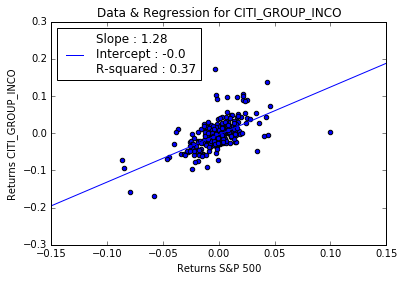

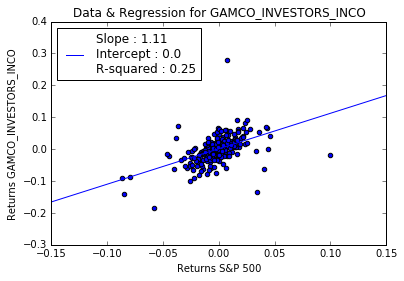

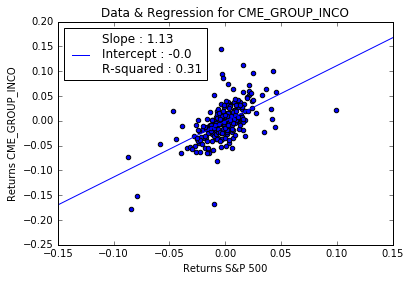

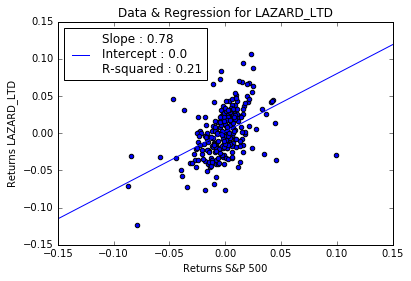

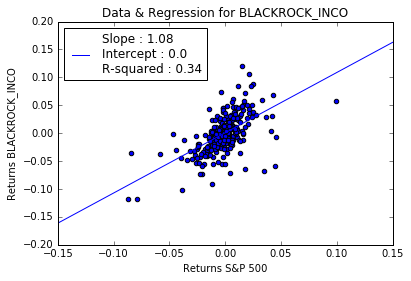

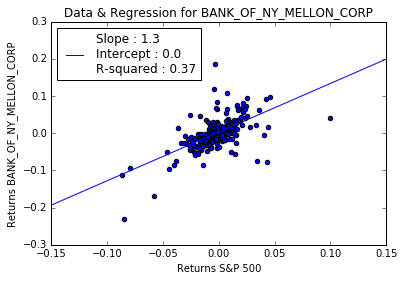

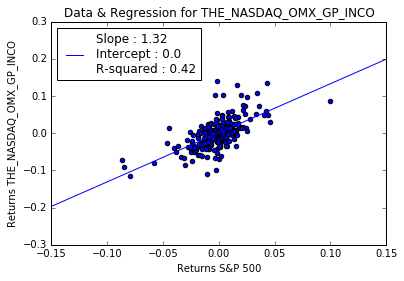

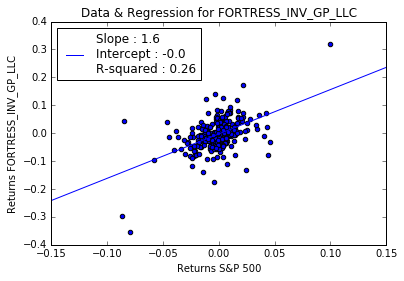

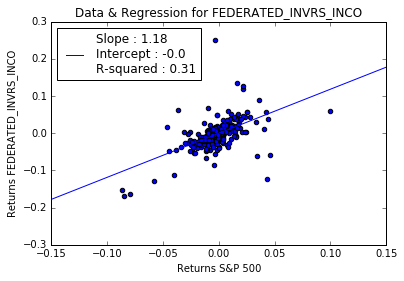

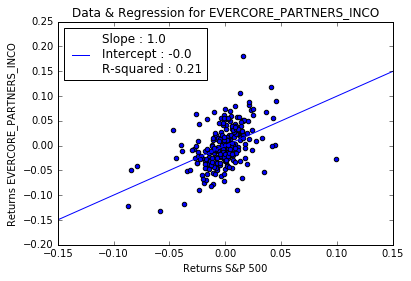

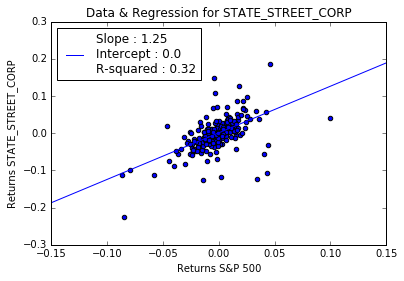

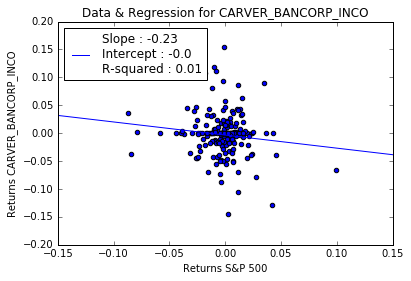

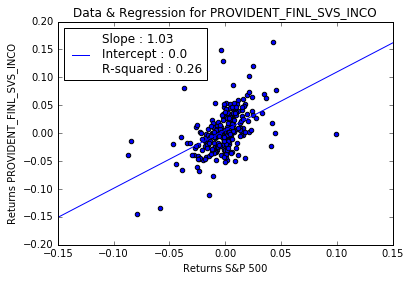

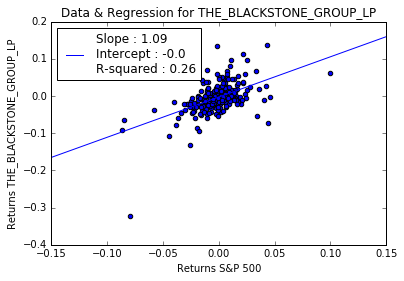

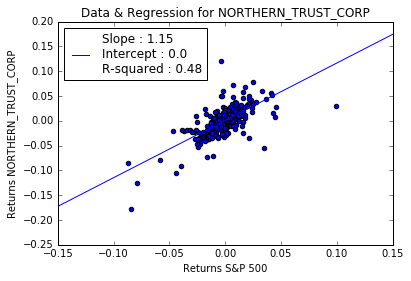

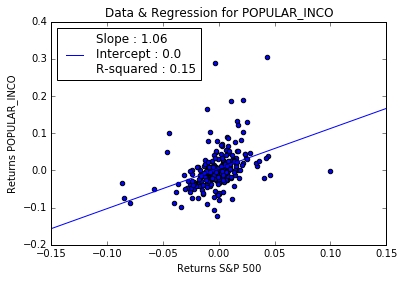

In [10]:
for company in Table_B.columns.values:
        if company=='SP_500_Index':
            continue
        fig, ax = plt.subplots()
        ax.scatter(Table_B['SP_500_Index'],(Table_B[company]))
        plt.title("Data & Regression for "+company)
        plt.ylabel("Returns "+company)
        plt.xlabel("Returns S&P 500")
        slope=Reg_params[company]['b_slope']
        c=Reg_params[company]['a_intercept']
        x_min, x_max = ax.get_xlim()
        y_min= c+slope*x_min, 
        y_max=c +slope*(x_max-x_min) +(y_min)
        ax.plot([x_min, x_max], [y_min, y_max])
        ax.set_xlim([x_min, x_max])
        ax.legend(["Slope : " + (str(round(Reg_params[company]['b_slope'],2))) + 
        " \nIntercept : " + (str(round(Reg_params[company]['a_intercept'],2))) +
        " \nR-squared : " + (str(round(Reg_params[company]['R_squared'],2))) ],
                                       loc='upper left')
       



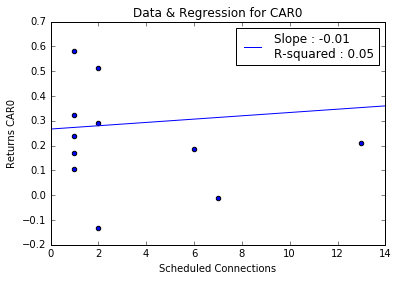

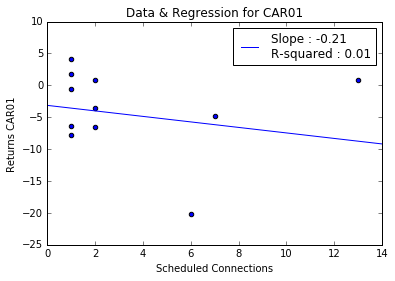

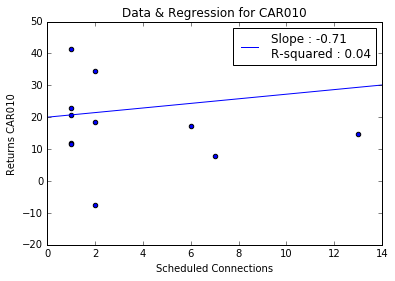

In [11]:
for CAR_type in Reg_Sch_Conn.columns.values:
        if CAR_type=='Scheduled_Conn':
            continue            
        fig, ax = plt.subplots()
        ax.scatter(Reg_Sch_Conn['Scheduled_Conn'],Reg_Sch_Conn[CAR_type])
        plt.title("Data & Regression for "+CAR_type)
        plt.ylabel("Returns "+CAR_type)
        plt.xlabel("Scheduled Connections")
        slope=Car_params_Sch[CAR_type]['b_slope']
        c=Car_params_Sch[CAR_type]['a_intercept']
        x_min, x_max = ax.get_xlim()
        y_min= c+slope*x_min, 
        y_max=c +slope*(x_max-x_min) +(y_min)
        ax.plot([x_min, x_max], [y_min, y_max])
        ax.set_xlim([x_min, x_max])
        ax.legend(["Slope : " + (str(round(Car_params_Sch[CAR_type]['b_slope'],2))) + 
        " \nR-squared : " + (str(round(Car_params_Sch[CAR_type]['R_squared'],2))) ],
                                       loc='upper right')


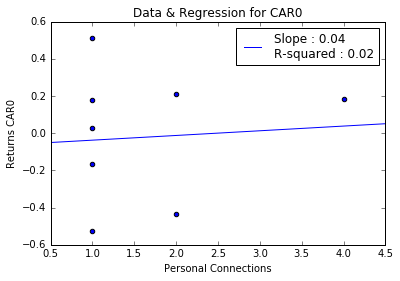

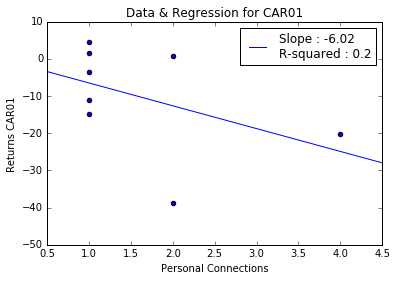

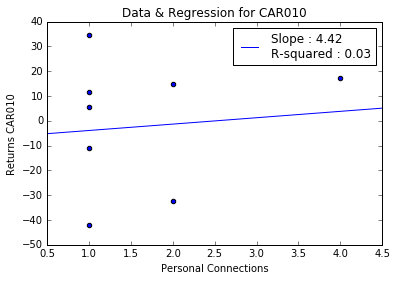

In [12]:
for CAR_type in Reg_Per_Conn.columns.values:
        if CAR_type=='Personal_Conn':
            continue            
        fig, ax = plt.subplots()
        ax.scatter(Reg_Per_Conn['Personal_Conn'],Reg_Per_Conn[CAR_type])
        plt.title("Data & Regression for "+CAR_type)
        plt.ylabel("Returns "+CAR_type)
        plt.xlabel("Personal Connections")
        slope=Car_params_Per[CAR_type]['b_slope']
        c=Car_params_Per[CAR_type]['a_intercept']
        x_min, x_max = ax.get_xlim()
        y_min= c+slope*x_min, 
        y_max=c +slope*(x_max-x_min) +(y_min)
        ax.plot([x_min, x_max], [y_min, y_max])
        ax.set_xlim([x_min, x_max])
        ax.legend(["Slope : " + (str(round(Car_params_Per[CAR_type]['b_slope'],2))) + 
        " \nR-squared : " + (str(round(Car_params_Per[CAR_type]['R_squared'],2))) ],
                                       loc='upper right')
